In [81]:
Name: Dohyun Kim
Student number: 1007372843
import pymc as pm
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt 
import arviz as az

n,loc_true,scale_true,df_true = 100,10,2,15
x = stats.t(df=df_true, loc=loc_true, scale=scale_true).rvs(n)

m_gibbs_model = pm.Model()

with m_gibbs_model:
    loc = pm.Normal("loc", mu=0, sigma=10)
    scale = pm.HalfNormal("scale", sigma=1)
    df = pm.Uniform("df", lower=1, upper=100)
    x_obs = pm.StudentT("likelihood", nu=df, mu=loc, sigma=scale, observed=x)
    
    m_gibbs_HMC = pm.sample(random_seed=1007372843)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [loc, scale, df]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


All 4 sampling chains did not show any divergence.

/opt/conda/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/opt/conda/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/opt/conda/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/opt/conda/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning:

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

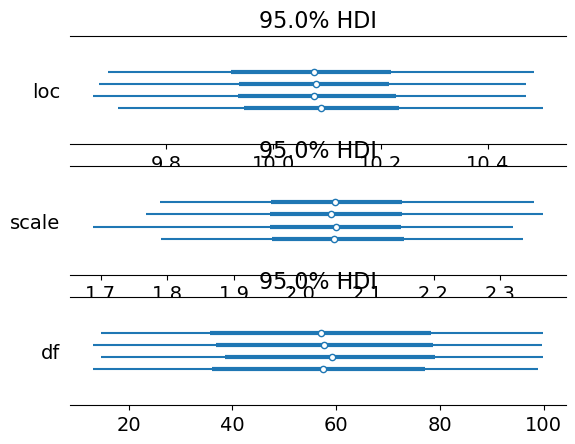

In [83]:
fig,ax = plt.subplots(3,1)
az.plot_forest(m_gibbs_HMC, var_names=["loc"], combined=False, hdi_prob=0.95, ax=ax[0])
az.plot_forest(m_gibbs_HMC, var_names=["scale"], combined=False, hdi_prob=0.95, ax=ax[1])
az.plot_forest(m_gibbs_HMC, var_names=["df"], combined=False, hdi_prob=0.95, ax=ax[2])

Text(0.5, 1.0, 'df')

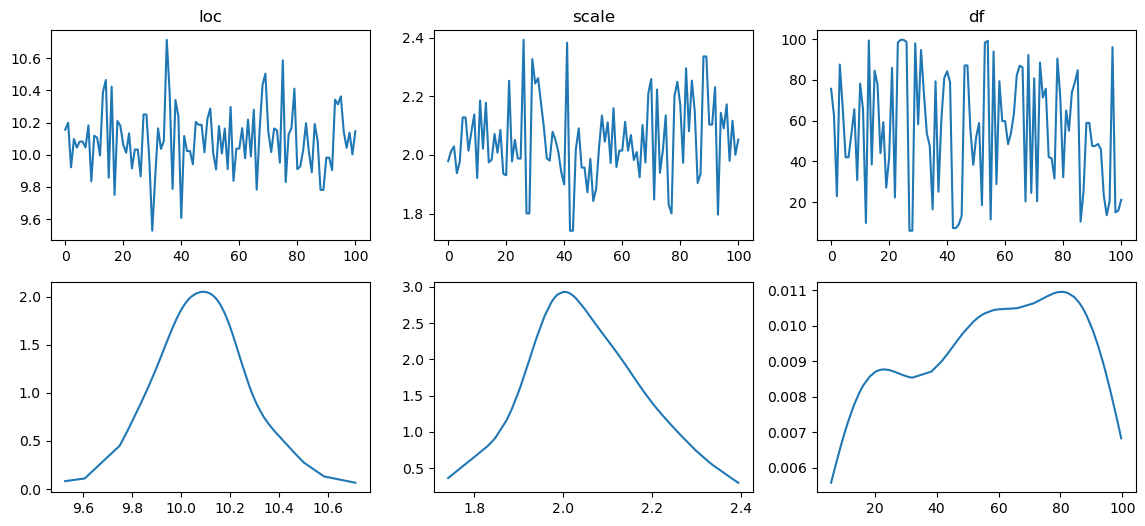

In [82]:
from scipy.stats import gaussian_kde

fig,ax = plt.subplots(2,3, figsize=(14,6))
n_mcmc_samples = 100

mcmc_chain = m_gibbs_HMC.posterior["loc"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values
mcmc_chain_sorted = sorted(mcmc_chain)
ax[0,0].plot(mcmc_chain)
ax[1,0].plot(mcmc_chain_sorted,gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted))
ax[0,0].set_title("loc")

mcmc_chain = m_gibbs_HMC.posterior["scale"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values
mcmc_chain_sorted = sorted(mcmc_chain)
ax[0,1].plot(mcmc_chain)
ax[1,1].plot(mcmc_chain_sorted,gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted))
ax[0,1].set_title("scale")

mcmc_chain = m_gibbs_HMC.posterior["df"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values
mcmc_chain_sorted = sorted(mcmc_chain)
ax[0,2].plot(mcmc_chain)
ax[1,2].plot(mcmc_chain_sorted,gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted))
ax[0,2].set_title("df")

They all seems to be converging to a point. However, df shows very high difference between a sample and the next sample. Also the shape of the bottom graph for df shows several local maxima.

In [84]:
print("Number of MCMC samples: ", m_gibbs_HMC.posterior['loc'].values.flatten().shape[-1])
az.summary(m_gibbs_HMC, round_to=2)

Number of MCMC samples:  4000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
loc,10.08,0.21,9.71,10.47,0.0,0.00,4313.27,2809.48,1.0
scale,2.06,0.15,1.79,2.34,0.0,0.00,3967.29,2420.21,1.0
df,56.87,25.61,15.48,99.92,0.4,0.29,3605.61,2366.36,1.0


The Number of MCMC samples is 4000. The bulk effective sample size for df is 3605.61, and the tail effective sample size for df is about 2366.36. The bulk effective sample size is close to the MCMC sample size, but the tail effective sample size is less than the MCMC sample size. This suggests that there are some correlations between samples in tail of the distribution.

HMC Split-Rhats {'loc': 1.0001, 'scale': 0.9997, 'df': 1.0008} | 

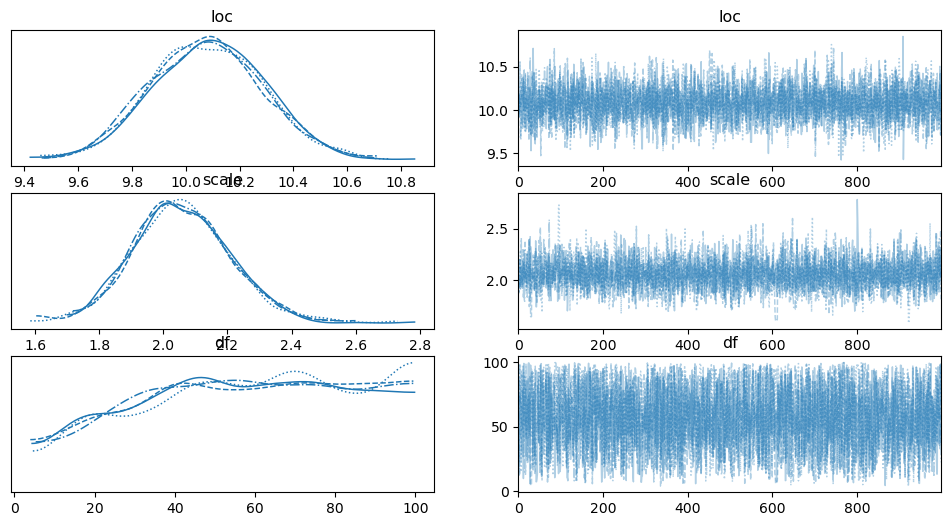

In [86]:
az.plot_trace(m_gibbs_HMC)
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(m_gibbs_HMC).items()}, end=' | ')

Rhats for 'loc', 'scale', and 'df' is all less than or equal to 1.05, which mean that those chains are indistinguishable chains when the initial values are different.

Autocorrelation for HMC (loc) chain -0.08994510108306912
Autocorrelation for HMC (scale) chain -0.0679064756936206
Autocorrelation for HMC (df) chain -0.036200089853447824


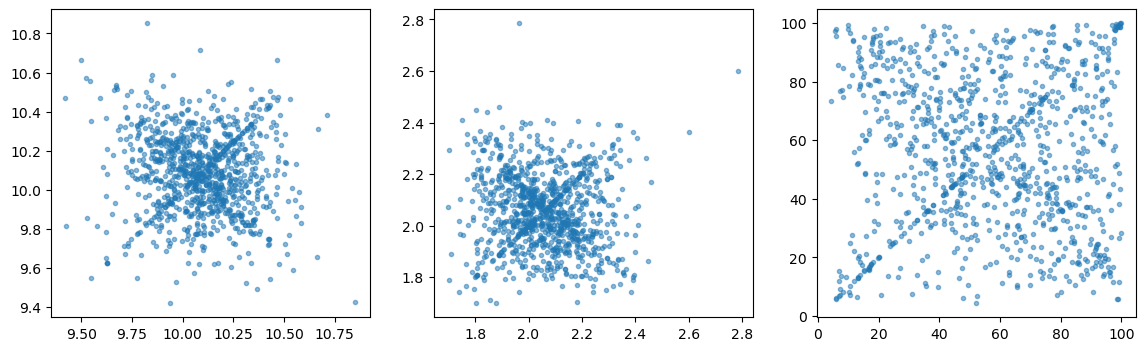

In [87]:
fig,ax = plt.subplots(1,3, figsize=(14,4))

max_mcmc_samples = 1000
mcmc_chain = m_gibbs_HMC.posterior["loc"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values; mcmc_chain_one_step_ahead = m_gibbs_HMC.posterior["loc"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values; ax[0].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)
print("Autocorrelation for HMC (loc) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])
mcmc_chain = m_gibbs_HMC.posterior["scale"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values; mcmc_chain_one_step_ahead = m_gibbs_HMC.posterior["scale"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values; ax[1].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5);
print("Autocorrelation for HMC (scale) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])
mcmc_chain = m_gibbs_HMC.posterior["df"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values; mcmc_chain_one_step_ahead = m_gibbs_HMC.posterior["df"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values; ax[2].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5);
print("Autocorrelation for HMC (df) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])

All parameters show small negative correlation.

In [92]:
# (d) Metropolis-Hastings acceptance rates
print(m_gibbs_HMC.sample_stats.acceptance_rate.values.flatten())
print("The mean acceptance rate is: ", np.mean(m_gibbs_HMC.sample_stats.acceptance_rate.values.flatten()))

[0.73364482 1.         0.76913985 ... 1.         1.         0.86125393]
The mean acceptance rate is:  0.8191293084755333


In [93]:
# Eight Schools example

J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

import logging
_log = logging.getLogger("pymc")
_log.setLevel(logging.INFO)
    

with pm.Model() as Centered_eight:

    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta = pm.Normal("theta", mu=mu, sigma=tau, shape=J)
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)
    SEED = [20100420, 20134234]
    fit_C = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                      return_inferencedata=True, idata_kwargs={"log_likelihood": True})

with pm.Model() as NonCentered_eight:

    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta_tilde = pm.Normal("theta_t", mu=0, sigma=1, shape=J)
    theta = pm.Deterministic("theta", mu + tau * theta_tilde)
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)
    fit_NC = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                       return_inferencedata=True, idata_kwargs={"log_likelihood": True})


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, tau, theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, tau, theta_t]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Centered eight schools model caused 433 divergences, but non-centered eight schools model caused only 12 divergences. 

In [114]:
print("Number of MCMC samples (Centered): ", fit_C.posterior['mu'].values.flatten().shape[-1])
az.summary(fit_C, round_to=2)

Number of MCMC samples (Centered):  10000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,4.23,3.33,-1.67,10.86,0.13,0.10,741.87,559.26,1.00
theta[0],6.34,5.90,-3.69,17.91,0.16,0.11,1179.23,2851.28,1.00
theta[1],4.95,4.97,-4.81,14.13,0.13,0.10,1365.98,4333.22,1.00
theta[2],3.69,5.56,-6.23,14.64,0.12,0.11,1754.17,3517.99,1.00
theta[3],4.63,4.94,-4.40,14.18,0.11,0.10,1807.94,5272.68,1.00
theta[4],3.27,4.76,-5.54,12.86,0.11,0.12,1724.37,3452.88,1.01
theta[5],3.78,5.10,-6.05,13.26,0.11,0.09,1959.60,3571.33,1.01
theta[6],6.50,5.29,-2.85,16.75,0.16,0.11,1087.23,3476.70,1.00
theta[7],4.81,5.51,-5.72,14.96,0.12,0.08,1946.86,4318.71,1.00
tau,4.13,3.24,0.69,10.05,0.18,0.13,59.84,20.08,1.04


In [115]:
print("Number of MCMC samples (Non-centered): ", fit_NC.posterior['mu'].values.flatten().shape[-1])
az.summary(fit_NC, round_to=2)

Number of MCMC samples (Non-centered):  10000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,4.41,3.27,-1.90,10.42,0.03,0.02,11903.60,6680.07,1.0
theta_t[0],0.32,0.96,-1.47,2.14,0.01,0.01,11852.45,7047.14,1.0
theta_t[1],0.10,0.93,-1.69,1.83,0.01,0.01,15651.36,7495.38,1.0
theta_t[2],-0.08,0.97,-1.83,1.81,0.01,0.01,16057.59,7168.45,1.0
theta_t[3],0.06,0.95,-1.70,1.84,0.01,0.01,14902.11,7324.68,1.0
theta_t[4],-0.16,0.94,-1.93,1.63,0.01,0.01,16499.83,7639.02,1.0
theta_t[5],-0.07,0.96,-1.85,1.73,0.01,0.01,13772.90,7344.10,1.0
theta_t[6],0.36,0.95,-1.43,2.14,0.01,0.01,13822.12,7340.51,1.0
theta_t[7],0.07,0.98,-1.83,1.87,0.01,0.01,14590.20,7186.53,1.0
tau,3.63,3.28,0.00,9.46,0.05,0.04,5956.38,4441.06,1.0


Non-centered model shows much higher effective sample sizes for both bulk and tail. This suggests that the samples in non-centered model is much less correlated with each other (i.e. independent).

In [113]:
print("HMC Split-Rhats (Centered)", {k: np.round(v.values,4) for k,v in az.rhat(fit_C).items()})
print("HMC Split-Rhats (Non-Centered)", {k: np.round(v.values,4) for k,v in az.rhat(fit_NC).items()})

HMC Split-Rhats (Centered) {'mu': 1.0022, 'theta': array([1.0021, 1.0017, 1.0047, 1.0028, 1.0076, 1.0056, 1.0028, 1.0041]), 'tau': 1.0355}
HMC Split-Rhats (Non-Centered) {'mu': 0.9999, 'theta_t': array([1.0003, 1.0001, 1.0002, 1.    , 1.0002, 1.0003, 1.0002, 1.0002]), 'tau': 1.0004, 'theta': array([0.9999, 1.    , 1.0001, 1.0003, 1.    , 1.    , 1.    , 1.0001])}


All Rhats do not exceed 1.05.

In [118]:
print(fit_C.sample_stats.acceptance_rate.values.flatten())
print("Mean acceptance rate for Centered model: ", np.mean(fit_C.sample_stats.acceptance_rate.values.flatten()))

[0.9339     0.650432   0.92738656 ... 0.90158151 0.21343995 0.20100958]
Mean acceptance rate for Centered model:  0.732826770300868


In [119]:
print(fit_NC.sample_stats.acceptance_rate.values.flatten())
print("Mean acceptance rate for Non-centered model: ", np.mean(fit_NC.sample_stats.acceptance_rate.values.flatten()))

[0.96584575 0.96401304 0.95955225 ... 0.91078674 0.86984342 0.94029322]
Mean acceptance rate for Non-centered model:  0.8145767334704715


Non-centered model has higher mean acceptance rate than centered model.

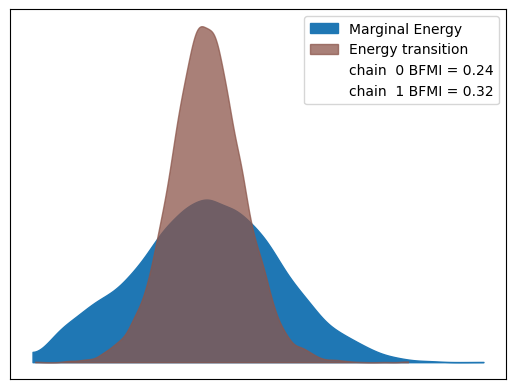

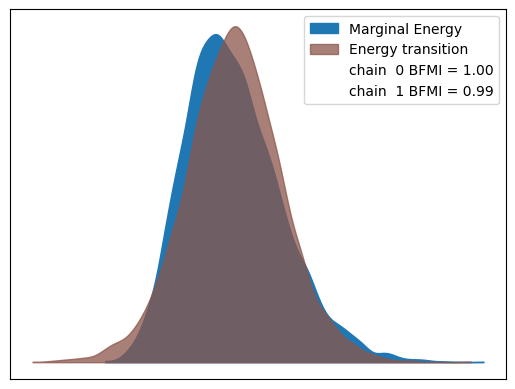

In [120]:
az.plot_energy(fit_C);
az.plot_energy(fit_NC);

Marginal energy and energy transition in centered model have huge differences in terms of their shape and covered area, whereas they almost overlap with each other in non-centered model. In centered model, energy transition is much narrower, which suggests that sampling did not cover tails of the true posterior, due to lack of energy. This will cause biased result. On the other hand, non-centered model shows mostly overlapping areas on the graph. This suggests that non-centered model explored the true posterior almost completely and the result from non-centered model will be unbiased.